# EJERCICIOS

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Concatenate
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError as RMSE

2025-01-28 18:52:20.547254: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 18:52:20.554441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 18:52:20.563321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 18:52:20.565804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 18:52:20.572531: I tensorflow/core/platform/cpu_feature_guar

In [2]:
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [3]:
# Verifica si TensorFlow detecta la GPU
if tf.config.list_physical_devices('GPU'):
    print("¡GPU encontrada!")
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("¡GPU no encontrada!")

¡GPU encontrada!
Num GPUs Available:  1


I0000 00:00:1738086755.152339   99362 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738086755.182182   99362 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738086755.182379   99362 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## EJERCICIO 1


Supongamos que queremos predecir dos objetivos diferentes (por ejemplo, precio y categoría) a partir de dos conjuntos de características diferentes (por ejemplo, características visuales y características de texto de un producto).

* Características visuales: un conjunto de 128 características numéricas, que podrían representar, por ejemplo, valores de píxeles o características extraídas de imágenes.
* Características de texto: un conjunto de 256 características numéricas, representando posiblemente la codificación de texto o características lingüísticas.
* Precio (Salida 1): un valor numérico que representa el precio de un producto.
* Categoría (Salida 2): una etiqueta de categoría, que asumiremos que puede tomar 10 valores diferentes (por ejemplo, 10 categorías diferentes de productos).

Voy a generar datos aleatorios

In [6]:
# Generación de datos ficticios
num_muestras = 1000  # Número de muestras en el conjunto de datos

# Características visuales: 128 características numéricas (x1)
caracteristicas_visuales = np.random.rand(num_muestras, 128)

# Características de texto: 256 características numéricas (x2)
caracteristicas_texto = np.random.rand(num_muestras, 256)

# Precio (Salida 1): Valor numérico (por ejemplo, precio de un producto) (y1)
precio = np.random.rand(num_muestras, 1)

# Categoría (Salida 2): 10 categorías posibles (codificadas en one-hot) y2
categorias = np.random.randint(0, 10, size=(num_muestras, 1))
categorias_one_hot = tf.keras.utils.to_categorical(categorias, num_classes=10)

Divide los datos en entrenamiento y prueba

In [7]:
x_temp_vis, x_test_vis, x_temp_txt, x_test_txt, y_temp_prec, y_test_prec, y_temp_cat, y_test_cat = train_test_split(
    caracteristicas_visuales,
    caracteristicas_texto,
    precio,
    categorias_one_hot,
    test_size=0.2,
    random_state=17)


x_train_vis, x_val_vis, x_train_txt, x_val_txt, y_train_prec, y_val_prec, y_train_cat, y_val_cat = train_test_split(
    x_temp_vis,
    x_temp_txt,
    y_temp_prec,
    y_temp_cat,
    test_size=0.2,
    random_state=17)

In [8]:
print("x_train_vis:",x_train_vis.shape)
print("x_val_vis:",x_val_vis.shape)
print("x_test_vis:",x_test_vis.shape)

print("y_train_prec:",y_train_prec.shape)
print("y_val_prec:",y_val_prec.shape)
print("y_test_prec:",y_test_prec.shape)

print("-------------------------------------------")

print("x_train_txt:",x_train_txt.shape)
print("x_val_txt:",x_val_txt.shape)
print("x_test_txt:",x_test_txt.shape)

print("y_train_cat:",y_train_cat.shape)
print("y_val_cat:",y_val_cat.shape)
print("y_test_cat:",y_test_cat.shape)

x_train_vis: (640, 128)
x_val_vis: (160, 128)
x_test_vis: (200, 128)
y_train_prec: (640, 1)
y_val_prec: (160, 1)
y_test_prec: (200, 1)
-------------------------------------------
x_train_txt: (640, 256)
x_val_txt: (160, 256)
x_test_txt: (200, 256)
y_train_cat: (640, 10)
y_val_cat: (160, 10)
y_test_cat: (200, 10)


Construye el modelo:
* Crea dos ramas de entrada, una para cada tipo de características.
* Las ramas se fusionarán para predecir el precio.
* Una de las ramas se utilizará también para predecir la categoria.

El esquema es el siguiente:

<img src="./esquema_modelo_funcional.png" alt="esquema modelo funcional"/>

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(17)

input_layer_visual = tf.keras.layers.Input(shape=[128],name="Input_Visual") 
input_layer_texto = tf.keras.layers.Input(shape=[256],name="Input_Texto")  
hidden_layer_visual = tf.keras.layers.Dense(64,name="Oculta_Visual",activation="relu")
hidden_layer_texto = tf.keras.layers.Dense(128,name="Oculta_Texto",activation="relu")
output_layer_categorico = tf.keras.layers.Dense(10,activation="softmax",name="Salida_categorica")
output_layer_precio = tf.keras.layers.Dense(1,name="Salida_precio")

hidden_visual = hidden_layer_visual(input_layer_visual)
hidden_texto = hidden_layer_texto(input_layer_texto)
concat = tf.keras.layers.Concatenate()([hidden_visual, hidden_texto])
output_categorico = output_layer_categorico(hidden_texto)
output_precio = output_layer_precio(concat)

model = tf.keras.Model(inputs=[input_layer_visual, input_layer_texto], outputs=[output_categorico, output_precio])

I0000 00:00:1738084736.638769   55825 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738084736.638969   55825 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738084736.639045   55825 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738084736.697229   55825 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Texto         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Visual        │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Oculta_Texto        │ (None, 128)       │     32,896 │ Input_Texto[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Oculta_Visual       │ (None, 64)        │      8,256 │ Input_Visual[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ Oculta_Visual[0]… │
│ (Concatenate)       │                   │            │ Oculta_Texto[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Salida_categorica   │ (None, 10)        │      1,290 │ Oculta_Texto[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Salida_precio       │ (None, 1)         │        193 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,635 (166.54 KB)

 Trainable params: 42,635 (166.54 KB)

 Non-trainable params: 0 (0.00 B)

Comprueba creando una imagen del modelo que es igual que el que se pide

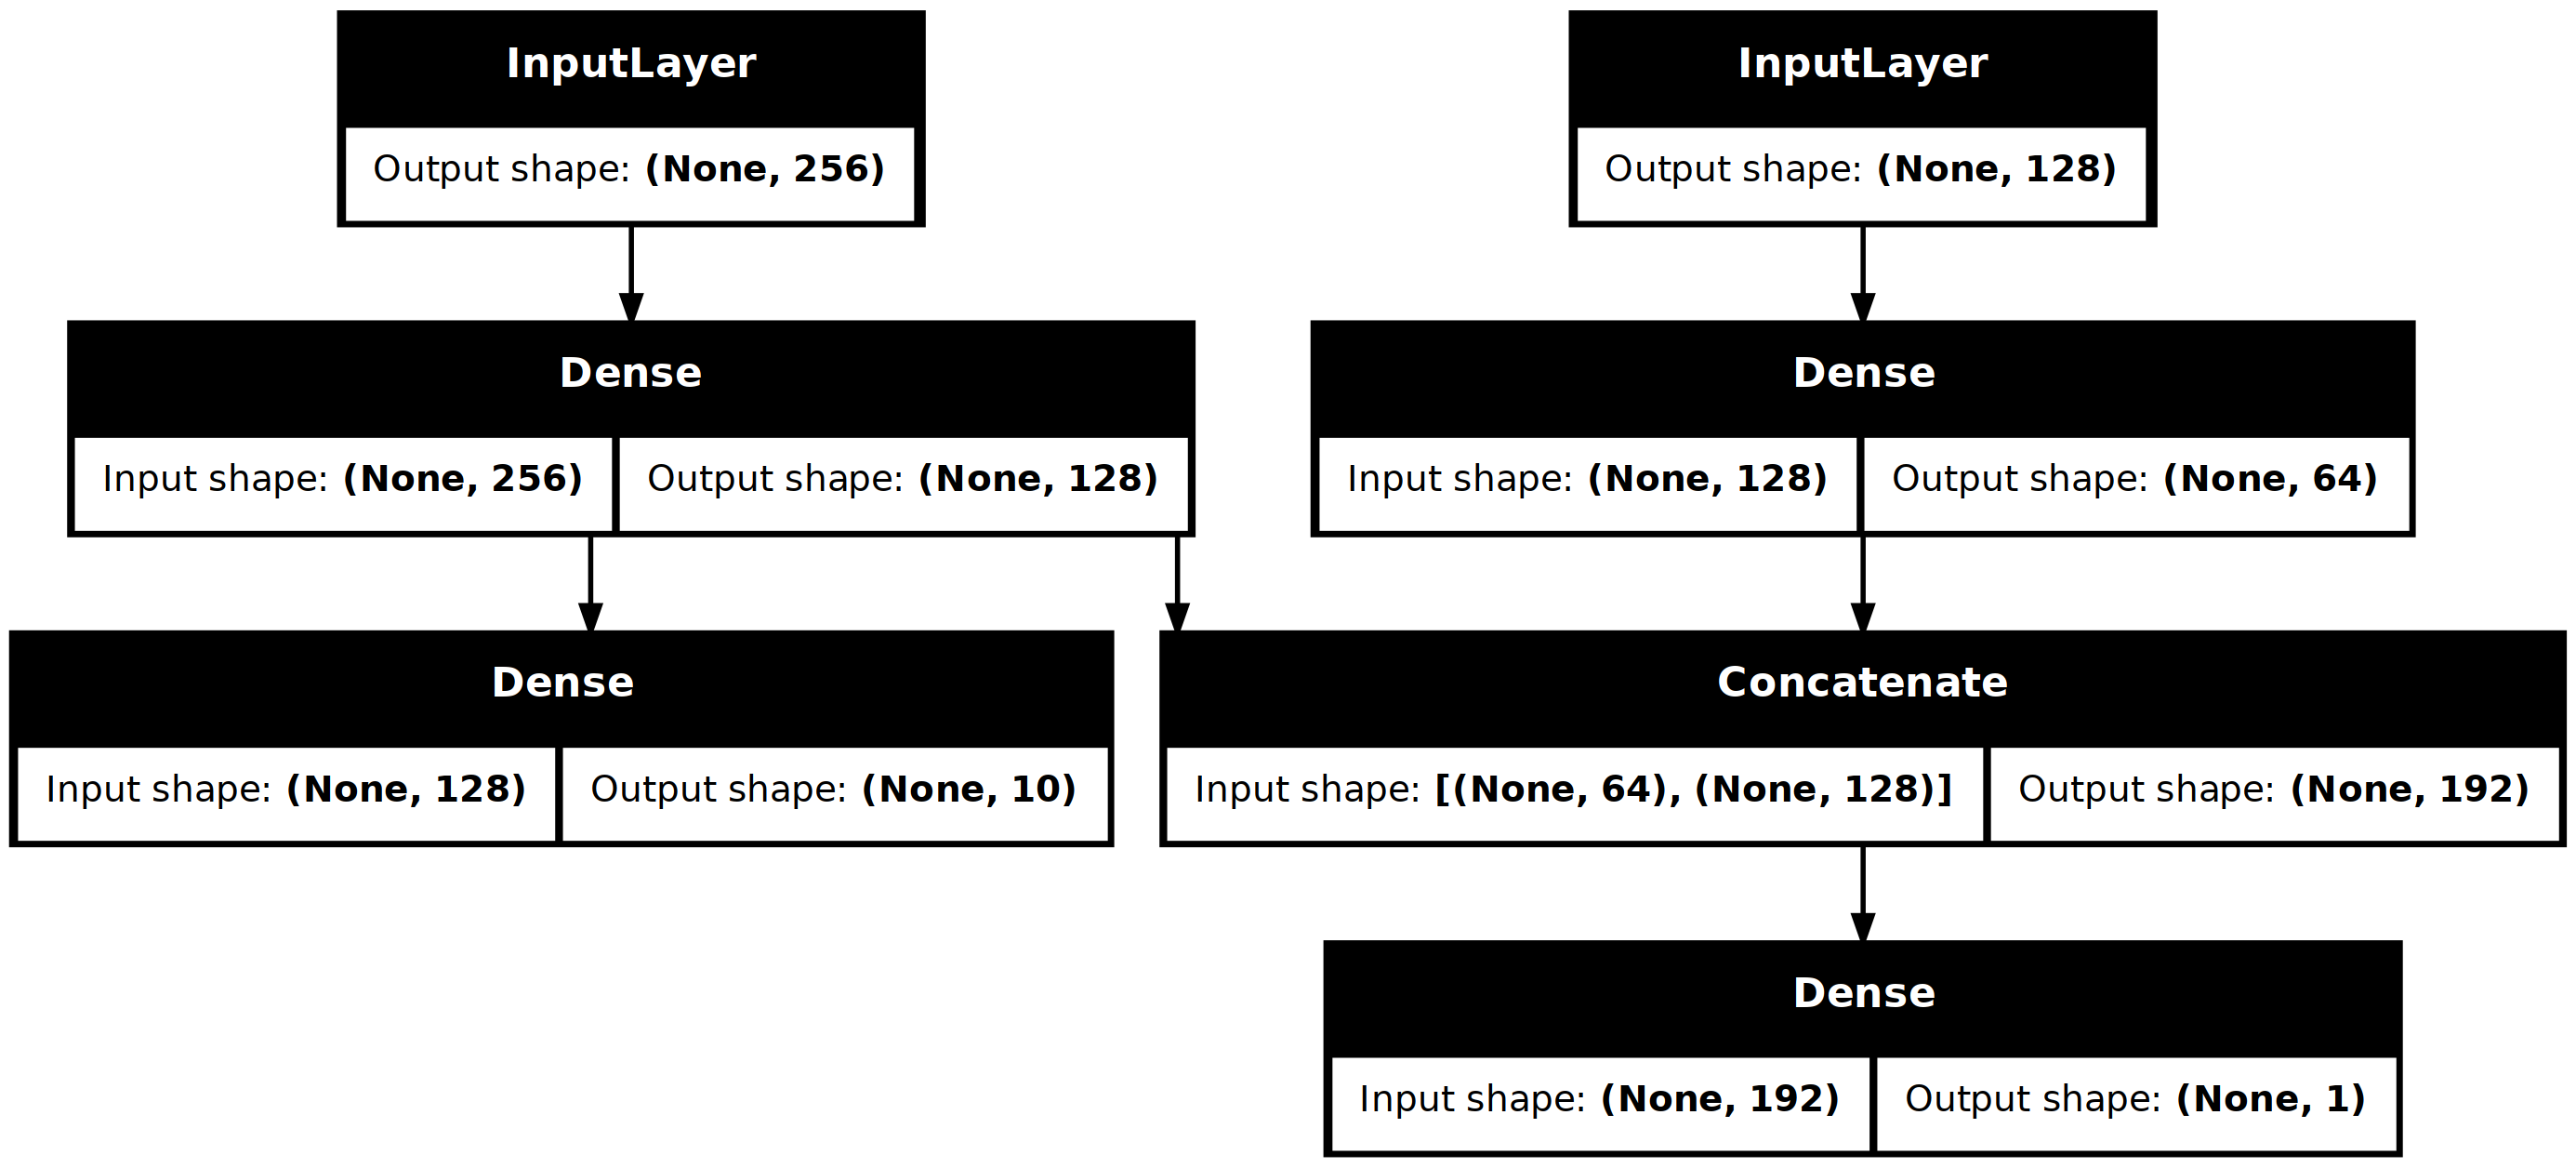

In [11]:
tf.keras.utils.plot_model(model, "resultados4_7/modelo_ejer1.png", show_shapes=True)

Compila el modelo especificando las pérdidas y métricas para cada salida (utiliza el optimizador Adam)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss={
        "Salida_categorica": "categorical_crossentropy",  # Clasificación
        "Salida_precio": "mse"  # Regresión
    },
    metrics={
        "Salida_categorica": ["accuracy"],  # Clasificación
        "Salida_precio": ["mae"]  # Regresión
    }
)


Entrena el modelo 

In [13]:
history=model.fit(
    [x_train_vis, x_train_txt],
    [y_train_cat, y_train_prec],
    epochs=30,
    batch_size=32,
    validation_data=((x_val_vis, x_val_txt), (y_val_cat, y_val_prec))
)

Epoch 1/30


/home/iabd/anaconda3/envs/IABD3_9/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Input_Visual', 'Input_Texto']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1738084748.032575   56100 service.cc:146] XLA service 0x74d694019700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738084748.032602   56100 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-01-28 18:19:08.049670: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-28 18:19:08.114717: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 9/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Salida_categorica_accuracy: 0.0986 - Salida_categorica_loss: 2.4041 - Salida_precio_loss: 0.6953 - Salida_precio_mae: 0.6843 - loss: 3.0529

I0000 00:00:1738084748.680748   56100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Salida_categorica_accuracy: 0.0909 - Salida_categorica_loss: 2.3946 - Salida_precio_loss: 0.5489 - Salida_precio_mae: 0.5980 - loss: 2.9434 - val_Salida_categorica_accuracy: 0.0625 - val_Salida_categorica_loss: 2.3345 - val_Salida_precio_loss: 0.1745 - val_Salida_precio_mae: 0.3469 - val_loss: 2.5090
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Salida_categorica_accuracy: 0.1061 - Salida_categorica_loss: 2.3209 - Salida_precio_loss: 0.1566 - Salida_precio_mae: 0.3192 - loss: 2.4774 - val_Salida_categorica_accuracy: 0.0688 - val_Salida_categorica_loss: 2.3330 - val_Salida_precio_loss: 0.1294 - val_Salida_precio_mae: 0.2910 - val_loss: 2.4625
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Salida_categorica_accuracy: 0.1487 - Salida_categorica_loss: 2.2854 - Salida_precio_loss: 0.1144 - Salida_precio_mae: 0.2798 - loss: 2.3997 - val_Salida_categorica_accuracy: 0.0688 - val_Salida_categorica_loss: 2.3257 - val_Salida_precio_loss: 0.1248

Evalúa el modelo en el conjunt de pruebas

In [14]:
model.evaluate(
    [x_test_vis, x_test_txt],  # Entradas de prueba
    [y_test_cat, y_test_prec]  # Salidas de prueba
)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - Salida_categorica_accuracy: 0.0689 - Salida_categorica_loss: 2.7041 - Salida_precio_loss: 0.1806 - Salida_precio_mae: 0.3580 - loss: 2.8768


[2.928403854370117,
 2.8126182556152344,
 0.14699064195156097,
 0.07500000298023224,
 0.3274732828140259]

## EJERCICIO 2

El objetivo de este ejercicio es entrenar un modelo en un subconjunto de clases (Modelo A) y luego usar este modelo para entrenar otro modelo en un subconjunto diferente de clases (Modelo B), primero sin y luego con el conocimiento transferido del Modelo A.

Carga los datos de CIFAR-10, representa alguna de sus imágenes con sus etiquetas, haz una lista con las etiquetas que tiene (busca en internet) y normaliza los datos dividiendo entre 255.0.

Divide los datos en conjuntos de entrenamiento, pruebas y validación para el modelo A y para el modelo B:
* El modelo A utiliza las clases "avión", "automóvil", "pájaro" y "gato" (0,1,2,3)
* El modelo B utiliza las clases "ciervo", "perro", "rana" y "caballo" (4,5,6,7)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
dicc={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [6]:
x_total = np.concatenate((x_train, x_test))
y_total = np.concatenate((y_train, y_test))

y_total_flat = y_total.flatten()

# Creamos las máscaras booleanas
mask_A = (y_total_flat >= 0) & (y_total_flat < 4)  # Valores [0, 1, 2, 3]
mask_B = (y_total_flat >= 4) & (y_total_flat < 8)  # Valores [4, 5, 6, 7]


# Usamos las máscaras para separar los datos
x_total_A = x_total[mask_A]
y_total_A = y_total[mask_A]

x_total_B = x_total[mask_B]
y_total_B = y_total[mask_B]


# Verificamos los resultados
print(f"Grupo A: {x_total_A.shape}, {y_total_A.shape}")
print(f"Grupo B: {x_total_B.shape}, {y_total_B.shape}")


# Dividir el conjunto completo en 50,000 para entrenamiento y 10,000 para validación + test
x_train_A, x_temp_A, y_train_A, y_temp_A = train_test_split(x_total_A, y_total_A, test_size=10000, random_state=17)

# Dividir los 10,000 restantes en 5,000 para validación y 5,000 para test
x_val_A, x_test_A, y_val_A, y_test_A = train_test_split(x_temp_A, y_temp_A, test_size=5000, random_state=17)

x_train_B, x_temp_B, y_train_B, y_temp_B = train_test_split(x_total_B, y_total_B, test_size=10000, random_state=17)

# Dividir los 10,000 restantes en 5,000 para validación y 5,000 para test
x_val_B, x_test_B, y_val_B, y_test_B = train_test_split(x_temp_B, y_temp_B, test_size=5000, random_state=17)


Grupo A: (24000, 32, 32, 3), (24000, 1)
Grupo B: (24000, 32, 32, 3), (24000, 1)


In [7]:
x_train_A = x_train_A.astype('float32') / 255.0
x_val_A = x_val_A.astype('float32') / 255.0
x_test_A = x_test_A.astype('float32') / 255.0

x_train_B = x_train_B.astype('float32') / 255.0
x_val_B = x_val_B.astype('float32') / 255.0
x_test_B = x_test_B.astype('float32') / 255.0

/tmp/ipykernel_99362/1174654790.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(dicc[int(y_train_A[i])])


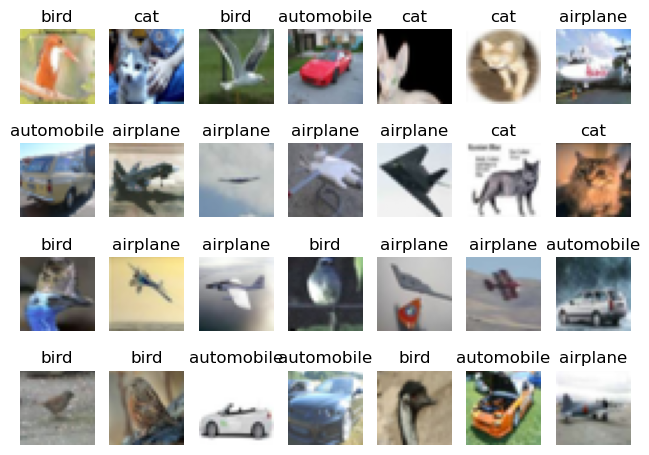

In [8]:
i=0
for x in x_train_A:
    plt.subplot(4,7,i+1)
    plt.title(dicc[int(y_train_A[i])])
    plt.imshow(x)
    plt.axis('off')
   
    if i == 27:
        break
    i+=1
plt.tight_layout()
plt.show()

/tmp/ipykernel_99362/1669133757.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(dicc[int(y_train_B[i])])


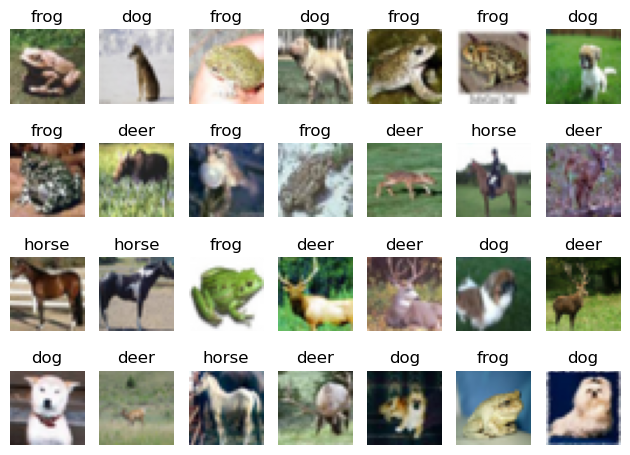

In [9]:
i=0
for x in x_train_B:
    plt.subplot(4,7,i+1)
    plt.title(dicc[int(y_train_B[i])])
    plt.imshow(x)
    plt.axis('off')
   
    if i == 27:
        break
    i+=1
plt.tight_layout()
plt.show()

Entrena el Modelo A

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(17)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)

I0000 00:00:1738086780.994316   99362 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738086780.994528   99362 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738086780.994603   99362 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738086781.046673   99362 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:
model_A = Sequential(
        [
            Input(shape=(32, 32,3)),
            Flatten(),
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(4, activation="softmax"),
        ]
)



model_A.compile(loss="sparse_categorical_crossentropy",
            optimizer=optimizer,
            metrics=["accuracy"])

In [12]:
history_A=model_A.fit(x_train_A, y_train_A, epochs=75, validation_data=(x_val_A, y_val_A),callbacks=early_stopping_cb)
model_A.save("resultados4_7/my_model_A.keras")

Epoch 1/75


I0000 00:00:1738086787.068364   99498 service.cc:146] XLA service 0x735cf4006f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738086787.068395   99498 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-01-28 18:53:07.077020: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-28 18:53:07.098329: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-01-28 18:53:07.884082: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_250', 36 bytes spill stores, 40 bytes spill loads



255/438 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.3123 - loss: 1.3993

I0000 00:00:1738086788.508790   99498 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3391 - loss: 1.3740 - val_accuracy: 0.4620 - val_loss: 1.2445
Epoch 2/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.5021 - loss: 1.2166 - val_accuracy: 0.5260 - val_loss: 1.1505
Epoch 3/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.5484 - loss: 1.1304 - val_accuracy: 0.5616 - val_loss: 1.0953
Epoch 4/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.5769 - loss: 1.0786 - val_accuracy: 0.5750 - val_loss: 1.0586
Epoch 5/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5905 - loss: 1.0436 - val_accuracy: 0.5876 - val_loss: 1.0322
Epoch 6/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.6013 - loss: 1.0177 - val_accuracy: 0.5954 - val_loss: 1.0118
Epoch 7/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.6103 - loss: 0.9977 - val_accuracy: 0.6034 - val_loss: 0.9949
Epoch 8/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6158 - loss: 0.9804 - val_accuracy:

Entrenar el Modelo B desde 0

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(17)

optimizer = tf.keras.optimizers.Adam()

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)

In [26]:
model_B = Sequential(
        [
            Input(shape=(32, 32,3)),
            Flatten(),
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(4, activation="softmax"),
        ]
)



model_B.compile(loss="sparse_categorical_crossentropy",
            optimizer=optimizer,
            metrics=["accuracy"])

In [27]:
history_B=model_B.fit(x_train_B, y_train_B, epochs=75, validation_data=(x_val_B, y_val_B),callbacks=early_stopping_cb)

Epoch 1/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.0000e+00 - l

Entrenar el Modelo B utilizando las capas aprendidas del Modelo A (excepto la capa de salida)

In [79]:
tf.keras.backend.clear_session()
tf.random.set_seed(17)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)

In [80]:
# Se transfieren todas las capas menos la última del modelo A al modelo B
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
#Se crea una nueva capa densa con 1 neurona y función de activación sigmoidal para la clasificación binaria
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid",name="salida"))
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [81]:

model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Evaluar los dos modelos para el conjunto de datos B en el conjunto de pruebas

In [82]:
history_B_on_A=model_B_on_A.fit(x_train_B, y_train_B, epochs=75, validation_data=(x_val_B, y_val_B),callbacks=early_stopping_cb)

Epoch 1/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.0000e+00 -

¿En este caso merece la pena?